This example shows how to use odeBLP to solve a system of ordinary differential equations (Lotka-Volterra system) using Differential Evolution, where both bootstrapping and profile likelihood are demonstrated.

Data and model used in this example were obtained from:\
https://github.com/systemsmedicine/PDE_params/tree/master/examples

In [1]:
import odeBLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from collections import Counter
import os

In [2]:
dfLV_ex = pd.read_csv('LotkaVolterraData.csv')

dfLV_ex = dfLV_ex.rename(columns={"0":"t", "1":"x", "2":"y"})

dfLV_ex

,t,x,y
0,0.060606,0.325940,0.469672
1,0.060606,0.326474,0.475169
2,0.060606,0.317529,0.486987
3,0.070707,0.340549,0.492719
4,0.070707,0.324513,0.470383
...,...,...,...
277,0.989899,0.775512,0.317879
278,0.989899,0.781255,0.329717
279,1.000000,0.749026,0.306407
280,1.000000,0.778621,0.320268


In [3]:
def LVmodel(z, t, a, b):
    
    x, y = z

    dX = a*x*(1 - x) - b*x*y
    dY = b*x*y - y
    
    dy = [dX, dY]
    
    return dy

In [4]:
LV_sample_t, LV_unique_t = odeBLP.timeseries_pull(dfLV_ex, 't')

In [5]:
LV_obs_data = odeBLP.observedData_pull(dfLV_ex, ['x','y'])

In [6]:
a = 0.1, 10
b = 0.1, 10

bounds_xy = [a, b]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.3s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.4s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    6.1s finished


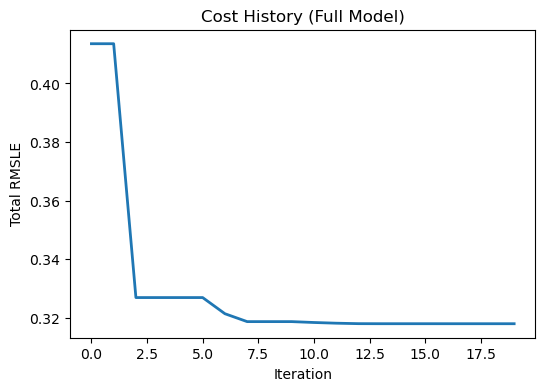

In [7]:
output_LV = odeBLP.DE_Generalized(LVmodel,                            # ODE model
                                  [0.3,0.5],                          # Initial conditions
                                  [LV_obs_data[0], LV_obs_data[1]],   # Observed data
                                  [LV_sample_t, LV_sample_t],         # Sample times
                                  [LV_unique_t, LV_unique_t],         # Unique times
                                  [a,b],                              # Parameter bounds 
                                  n_boot=10,                          # Number of bootstraps
                                  n_jobs=os.cpu_count() - 4,          # Number of CPU processors to use for bootstraps
                                  params_trans=['linear','linear'],   # Parameter transformations
                                  rmsle_return=True,                  # Return total and individual RMSLEs
                                  maxiter=10000,                      # Iterations
                                  tol=1e-5,                           # Error tolerance
                                  plot_cost_hist=True,                # Plots cost history
                                  ODE_names=['x','y'],                # Provides names for each ODE equation
                                  show_usage=False)                   # Shows usage for pulling results

In [8]:
LV_results = odeBLP.DE_Results(output_LV,                          # Output from DE_Generalized
                               LVmodel,                            # ODE model
                               [0.3,0.5],                          # Initial conditions
                               [LV_unique_t, LV_unique_t],         # Unique times 
                               bounds_xy,                          # Parameter bounds
                               conf_int=(2.5, 97.5),               # 95% confidence interval
                               params_trans=['linear','linear'],   # Parameter transformations
                               param_names=['a','b'],              # Parameter names
                               show_usage=False)                   # Shows usage for pulling results

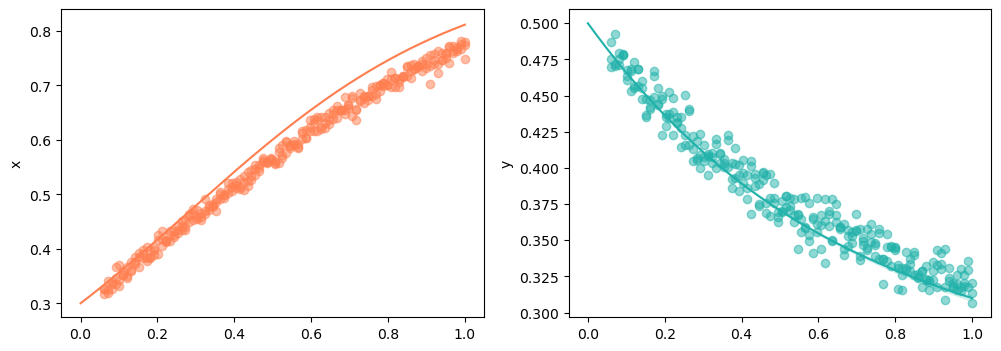

In [9]:
# BOOTSTRAP PLOT

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), facecolor='white')

y_scale_unlog = np.arange(0, 7, 1)

#######################################################
# X
ax[0].fill_between(LV_results['time'],
                   LV_results['Lower CI: Fit'][:, 0],
                   LV_results['Upper CI: Fit'][:, 0],
                   color='coral', alpha=0.2, linewidth=0)  # Plotting the 95% confidence interval ribbon
ax[0].plot(LV_results['time'],
           LV_results['Full ODE Solutions'][:, 0], color='coral', linestyle='-')   # Plotting the fitted curve
ax[0].scatter(dfLV_ex['t'], dfLV_ex['x'],
              color='coral', alpha = 0.5)
ax[0].set_ylabel('x')

#######################################################
# Y
ax[1].fill_between(LV_results['time'],
                   LV_results['Lower CI: Fit'][:, 1],
                   LV_results['Upper CI: Fit'][:, 1],
                   color='lightseagreen', alpha=0.2, linewidth=0)  # Plotting the 95% confidence interval ribbon
ax[1].plot(LV_results['time'],
           LV_results['Full ODE Solutions'][:, 1], color='lightseagreen', linestyle='-')   # Plotting the fitted curve
ax[1].scatter(dfLV_ex['t'], dfLV_ex['y'],
              color='lightseagreen', alpha = 0.5)
ax[1].set_ylabel('y')
#######################################################

plt.show()

In [10]:
LV_results['Parameter Table']

,Parameter,Estimate (Full Model),Lower CI,Upper CI,Parameter Bounds
0,a,3.211658,3.205146,3.233272,"(0.1, 10)"
1,b,0.893439,0.879652,0.905959,"(0.1, 10)"


In [11]:
pl_data = odeBLP.DE_profile_likelihood(LVmodel,                             # ODE model
                                       [0.3,0.5],                           # Initial conditions
                                       [LV_obs_data[0], LV_obs_data[1]],    # Observed data
                                       [LV_sample_t, LV_sample_t],          # Sample times
                                       [LV_unique_t, LV_unique_t],          # Unique times
                                       [a,b],                               # Parameter bounds
                                       n_points=100,                        # Number of grid points to check for fixed parameter
                                       params_trans=['linear','linear'],    # Parameter transformations
                                       param_names=['a', 'b'],              # Parameter names
                                       maxiter=10000,                       # Iterations
                                       tol=1e-5)                            # Error tolerance

pl_data

,Parameter,Value,Error
0,a,0.1,3.692281
1,a,0.2,3.536701
2,a,0.3,3.384697
3,a,0.4,3.236350
4,a,0.5,3.091739
...,...,...,...
195,b,9.6,10.232954
196,b,9.7,10.327452
197,b,9.8,10.421611
198,b,9.9,10.515437


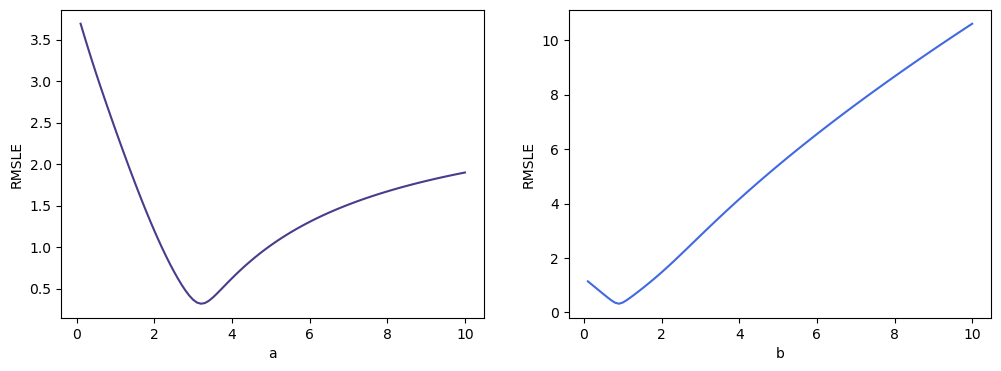

In [12]:
# PROFILE LIKELIHOOD PLOT

fig_pl, ax_pl = plt.subplots(nrows=1, ncols=2, figsize=(12,4), facecolor='white')

#######################################################
# a
ax_pl[0].plot(pl_data['Value'][pl_data['Parameter'] == 'a'],
           pl_data['Error'][pl_data['Parameter'] == 'a'], linestyle='-', color='darkslateblue')   # Plotting the profile likelihood of first parameter
ax_pl[0].set_xlabel('a')
ax_pl[0].set_ylabel('RMSLE')

#######################################################
# b
ax_pl[1].plot(pl_data['Value'][pl_data['Parameter'] == 'b'],
           pl_data['Error'][pl_data['Parameter'] == 'b'], linestyle='-', color='royalblue')   # Plotting the profile likelihood of the second parameter
ax_pl[1].set_xlabel('b')
ax_pl[1].set_ylabel('RMSLE')
#######################################################

plt.show()